In [1]:
import os
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve

import shap

import warnings
warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Leitura dos artefatos

In [2]:
model = pickle.load(
    open('../models/wrapped/model_pipeline_prod.pkl', 'rb')
)
model


Pipeline(steps=[('json_to_df', Json parser),
                ('seletor_1',
                 Feature Selector. Mode: train. Features: ['age', 'campaign', 'cons.conf.idx', 'cons.price.idx', 'contact', 'contacts_tendency', 'default', 'education', 'emp.var.rate', 'euribor3m', 'job', 'month', 'nr.employed', 'pdays', 'poutcome', 'previous', 'quarter', 'was_contacted_before']),
                ('cria_features', BuildFeatures()),
                ('...
                 Feature Selector. Mode: train. Features: ['age', 'campaign', 'cons.conf.idx', 'cons.price.idx', 'contact', 'contacts_tendency', 'default', 'education', 'emp.var.rate', 'euribor3m', 'job', 'month', 'nr.employed', 'pdays', 'poutcome', 'previous', 'quarter', 'was_contacted_before']),
                ('modelo',
                 LGBMClassifier(class_weight='balanced', eval_metric='auc',
                                learning_rate=0.01629792783423414, max_depth=6,
                                min_child_samples=79, n_estimators=219,
                                num_leaves=44, random_state=12))])

# Classificação

## Leitura das bases (treino e teste)

In [5]:
df_teste = pd.read_csv(os.path.join('..', 'data', 'train_test', 'test.csv'))

print(df_teste.shape)
df_teste.head()

(8236, 25)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,quarter,contacts_tendency,employment_status,was_contacted_before,y
0,27,student,single,high.school,unknown,yes,no,telephone,may,thu,...,1.1,93.994,-36.4,4.860,5191.0,2Q,0.0,not_employed,False,0
1,60,admin.,divorced,professional.course,no,yes,no,cellular,sep,wed,...,-1.1,94.199,-37.5,0.886,4963.6,3Q,1.0,employed,False,1
2,51,blue-collar,married,high.school,no,no,no,telephone,may,fri,...,1.1,93.994,-36.4,4.855,5191.0,2Q,0.0,employed,False,0
3,39,blue-collar,single,unknown,unknown,no,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,2Q,0.0,employed,False,0
4,35,blue-collar,married,basic.9y,unknown,no,no,telephone,may,fri,...,1.1,93.994,-36.4,4.864,5191.0,2Q,0.0,employed,False,0


In [6]:
df_treino = pd.read_csv(os.path.join('..', 'data', 'train_test', 'train.csv'))

print(df_treino.shape)
df_treino.head()

(32940, 25)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,quarter,contacts_tendency,employment_status,was_contacted_before,y
0,31,admin.,single,university.degree,no,no,no,cellular,sep,fri,...,-3.4,92.379,-29.8,0.803,5017.5,3Q,0.0,employed,False,0
1,39,housemaid,married,high.school,no,yes,no,telephone,may,fri,...,1.1,93.994,-36.4,4.857,5191.0,2Q,0.0,employed,False,0
2,34,entrepreneur,married,professional.course,no,yes,no,cellular,jul,thu,...,1.4,93.918,-42.7,4.958,5228.1,3Q,0.0,employed,False,0
3,36,technician,married,basic.9y,unknown,no,no,telephone,may,tue,...,1.1,93.994,-36.4,4.856,5191.0,2Q,0.0,employed,False,0
4,25,student,single,unknown,unknown,yes,no,cellular,aug,fri,...,-2.9,92.201,-31.4,0.825,5076.2,3Q,0.0,not_employed,False,0


In [7]:
seletor = pickle.load(
    open(os.path.join('..', 'models', 'encoders', 'seletor_2.pkl'), 'rb')
)

## Scoring

In [8]:
df_treino['score'] = (model.predict_proba(df_treino)[:,1]*1000).astype(int)
df_teste['score'] = (model.predict_proba(df_teste)[:,1]*1000).astype(int)

## Evaluation

In [9]:
roc_auc_score(
    df_treino['y'],
    df_treino['score']/1000
)

0.8299193877701765

In [10]:
roc_auc_score(
    df_teste['y'],
    df_teste['score']/1000
)

0.7970580530174549

In [11]:
booster = model[-1].booster_
importance = booster.feature_importance(importance_type='split')  

df_imp = pd.DataFrame({
    'feature': seletor.features,
    'imp': importance
}).sort_values(by='imp', ascending=False)


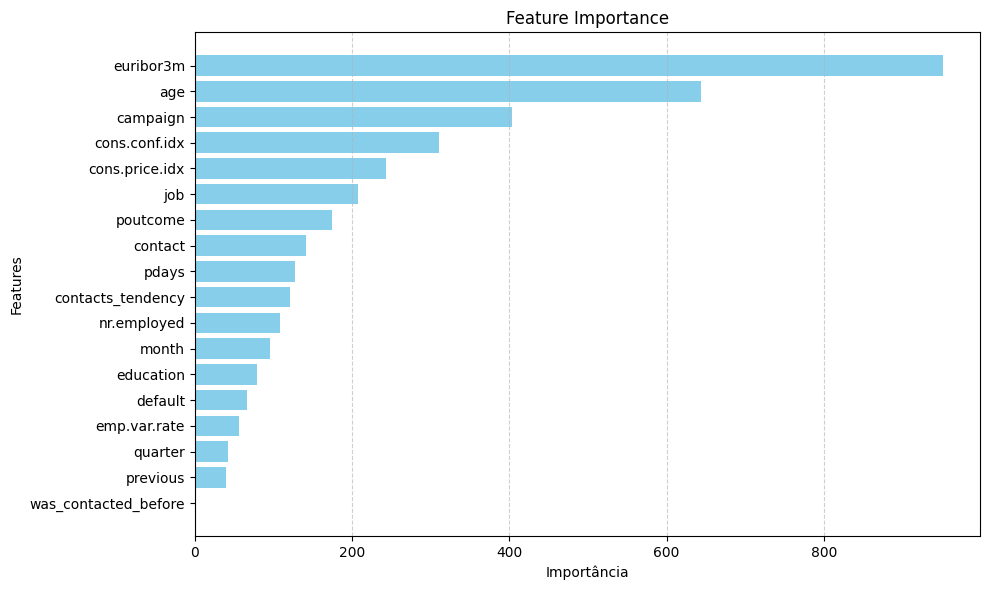

In [13]:
plt.figure(figsize=(10, 6))

plt.barh(df_imp['feature'], df_imp['imp'], color = 'skyblue')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.grid(axis = 'x', linestyle = '--', alpha = 0.6)

plt.tight_layout()
plt.show()

## Análise de resultados

In [21]:
df_teste['decil'] = pd.qcut(df_teste['score'], q=10, labels=False, duplicates='drop')
results = (df_teste.groupby('decil').y.sum()/df_teste.y.sum()).reset_index()
results['decil'] += 1

results

,decil,y
0,1,0.026455
1,2,0.026455
2,3,0.043386
3,4,0.033862
4,5,0.050794
5,6,0.062434
6,7,0.055026
7,8,0.063492
8,9,0.192593
9,10,0.445503


In [22]:
results['cust_prospected'] = df_teste[df_teste.y == 1].groupby('decil').size()
results['total_cust'] = df_teste.groupby('decil').size().astype(int)
results['not_cust_prospected'] = results['total_cust'] - results['cust_prospected']
results['score (>=)'] = round(df_teste.groupby('decil').score.min(), 3)

results.fillna(0, inplace=True)
results.sort_values(by='decil', ascending=False, inplace=True)
results = results[['decil', 'score (>=)', 'cust_prospected', 'not_cust_prospected', 'total_cust', 'y']]

In [23]:
results = results.rename(columns={'y': 'recall'})

results['recall'] = results['recall'].cumsum()
results['precision'] = results['cust_prospected'] / results['total_cust']
results['not_cust_prospected'] = results['not_cust_prospected'].cumsum()
results['total_cust'] = results['total_cust'].cumsum()

results.reset_index(drop=True, inplace=True)

results

,decil,score (>=),cust_prospected,not_cust_prospected,total_cust,recall,precision
0,10,786,421,399,820,0.445503,0.513415
1,9,495,182,1043,1646,0.638095,0.220339
2,8,379,60,1793,2456,0.701587,0.074074
3,7,343,52,2553,3268,0.756614,0.064039
4,6,313,59,3321,4095,0.819048,0.071342
5,5,281,48,4117,4939,0.869841,0.056872
6,4,257,32,4900,5754,0.903704,0.039264
7,3,231,41,5680,6575,0.947090,0.049939
8,2,196,25,6462,7382,0.973545,0.030979
9,1,48,25,7291,8236,1.000000,0.029274


Observa-se que o modelo ordena bem os itens, concentrando a maior parte dos positivos nos decis superiores: os três primeiros decis (10, 9 e 8) já recuperam cerca de 70% dos itens relevantes. A precisão é alta no decil 10 (52%) e cai rapidamente nos seguintes, indicando que os scores são informativos apenas nos valores mais altos. Assim, o modelo é eficaz para priorização, mas seu uso deve se concentrar nos decis superiores para evitar falsos positivos.

In [24]:
df_treino_encoded = pd.read_csv(os.path.join('..', 'data', 'train_test', 'train_encoded.csv'))
sample_train = df_treino_encoded[seletor.features].sample(frac = 0.3, random_state=98)

100%|===================| 9840/9882 [00:53<00:00]        

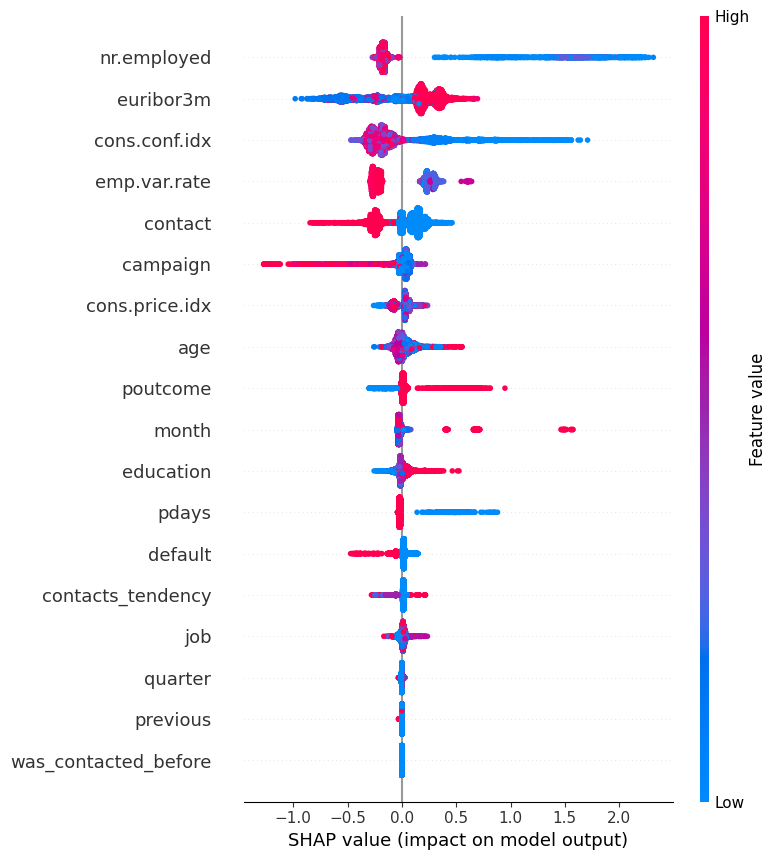

In [25]:
explainer = shap.Explainer(model[-1], sample_train)
shap_values = explainer(sample_train)

plt.figure(figsize = (10, 6))
shap.summary_plot(shap_values, sample_train)

### Análise de threshold

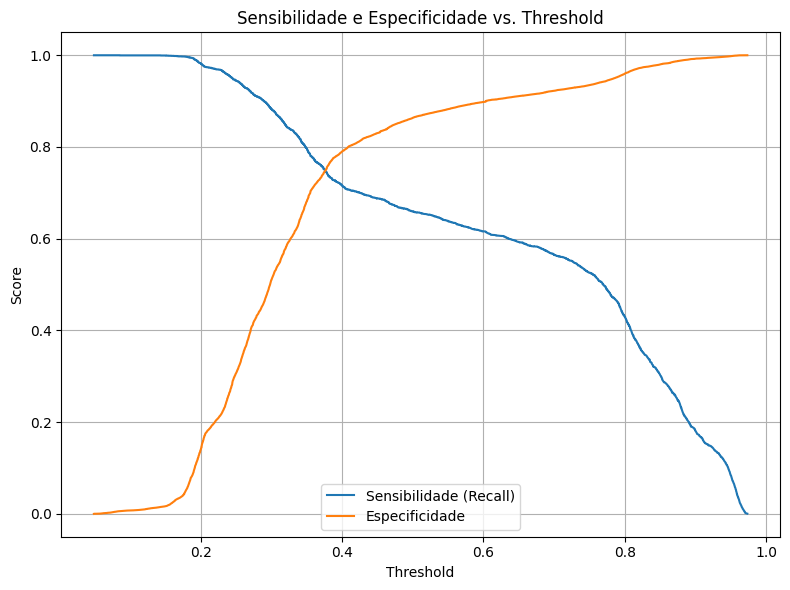

In [26]:
threshold_default = 0.5

df_treino['y_true'] = df_treino['y']
df_treino['score'] = model.predict_proba(df_treino)[:, 1] 
df_treino['y_pred'] = (df_treino['score'] >= threshold_default).astype(int)

report = classification_report(df_treino['y_true'], df_treino['y_pred'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

precision, recall, thresholds = precision_recall_curve(df_treino['y_true'], df_treino['score'])

specificity = []
for t in thresholds:
    y_pred_temp = (df_treino['score'] >= t).astype(int)
    tn = ((df_treino['y_true'] == 0) & (y_pred_temp == 0)).sum()
    fp = ((df_treino['y_true'] == 0) & (y_pred_temp == 1)).sum()
    specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)

plt.figure(figsize=(8, 6))

plt.plot(thresholds, recall[:-1], label='Sensibilidade (Recall)')
plt.plot(thresholds, specificity, label='Especificidade')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Sensibilidade e Especificidade vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [27]:
youden_j = np.array(recall[:-1]) + np.array(specificity)

best_idx = np.argmax(youden_j)
best_threshold = thresholds[best_idx]
print(f'Melhor threshold: {best_threshold:.3f}')

Melhor threshold: 0.525


In [28]:
df_treino['y_pred_best'] = (df_treino['score'] >= best_threshold).astype(int)

report_best = classification_report(df_treino['y_true'], df_treino['y_pred_best'])
print(report_best)

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     29246
           1       0.39      0.65      0.49      3694

    accuracy                           0.85     32940
   macro avg       0.67      0.76      0.70     32940
weighted avg       0.89      0.85      0.86     32940



In [29]:
df_teste['score'] = model.predict_proba(df_teste)[:, 1] 

In [30]:
df_teste['y_pred_best'] = (df_teste['score'] >= best_threshold).astype(int)

df_teste['y_true'] = df_teste['y']

report_teste = classification_report(df_teste['y_true'], df_teste['y_pred_best'])
print(report_teste)

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      7291
           1       0.38      0.63      0.48       945

    accuracy                           0.84      8236
   macro avg       0.67      0.75      0.69      8236
weighted avg       0.88      0.84      0.86      8236

